In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

# Import data

In [80]:
# import census-tract aggregated energy atlas data (from Pouya)
folder_path = Path('/Users/josephko/USC/Research/Anthropogenic Heat/energy_atlas/census_tract_level_data')
electricity_annual = pd.read_csv(folder_path / 'kwh_annual.csv')
electricity_monthly = pd.read_csv(folder_path / 'kwh_monthly.csv')
natgas_annual = pd.read_csv(folder_path /'therms_annual.csv')
natgas_monthly = pd.read_csv(folder_path / 'therms_monthly.csv')
census_tracts = gpd.read_file(folder_path / 'la-county-census-tracts.geojson')

# import neighborhood-aggregated energy atlas data
energy_atlas_data_path = Path('data/energy_atlas')
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['masked'])

# source: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
neighborhoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)


# Modify raw data

In [81]:
# === Modifications to dataframes === #

# change FIPS from str to int
census_tracts['FIPS'] = census_tracts['FIPS'].astype('int')

# change name FIPS column to match other dataframes 
census_tracts.rename(columns = {'FIPS':'geoid'}, inplace=True)

# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)

# make neighborhoods name all lower-case to match energy atlas name column
neighborhoods_lower = neighborhoods.copy()
neighborhoods_lower['name'] = neighborhoods_lower['name'].str.lower()
neighborhoods_lower.head()

# drop columns
cols_drop = ['external_i', 'slug', 'slug_1','display_na', 'set', 'name_1']
neighborhoods_lower.drop(cols_drop, axis=1, inplace=True)


# === Join geometries to dataframes === #

# merge geometries to census tract level data
electricity_annual_gdf = census_tracts.merge(electricity_annual, on = 'geoid')

# merge geometries to neighborhood level data
usage_bld = neighborhoods_lower.merge(usage_bld_btu, on='name')

# === Unit Conversions === #

# add column for usage in units of Joules (1 btu = 1055.06 joules)
usage_bld['usage_joules'] = usage_bld['usage']*1055.06

# add column for usage in units of kWh (3412.14 btu = 1 kwh)
usage_bld['usage_kwh'] = usage_bld['usage']/3412.14

In [82]:
usage_bld.head()

,name,location,latitude,sqmi,longitude,kind,type,geometry,geo_id,sqft,...,usage_med,usage_med_sqft,usetype,year,pct_elec,pct_ng,pop,usage_percap,usage_joules,usage_kwh
0,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,39.3391089485,34.497355239240846,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894...",neighborhoods_64,21120.0,...,NaN,NaN,agriculture,2016,NaN,NaN,NaN,NaN,NaN,NaN
1,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,39.3391089485,34.497355239240846,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894...",neighborhoods_64,610990.0,...,NaN,NaN,commercial,2016,NaN,NaN,NaN,NaN,NaN,NaN
2,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,39.3391089485,34.497355239240846,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894...",neighborhoods_64,NaN,...,NaN,NaN,condo,2016,NaN,NaN,NaN,NaN,NaN,NaN
3,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,39.3391089485,34.497355239240846,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894...",neighborhoods_64,1260.0,...,NaN,NaN,industrial,2016,NaN,NaN,NaN,NaN,NaN,NaN
4,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,39.3391089485,34.497355239240846,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894...",neighborhoods_64,45438.0,...,NaN,NaN,institutional,2016,NaN,NaN,NaN,NaN,NaN,NaN


# Plot data

In [84]:
usage_bld['usetype'].unique()

array(['agriculture', 'commercial', 'condo', 'industrial',
       'institutional', 'multi_family', 'other', 'residential_other',
       'residential_uncat', 'res_total', 'single_family', 'uncat'],
      dtype=object)

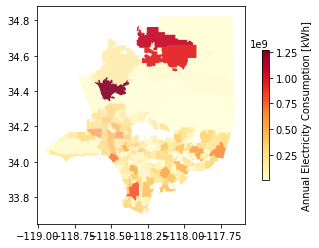

In [85]:
# testing: plot neighborhood level data
gdf_filter = usage_bld[usage_bld['usetype'] == 'res_total']
gdf_filter.plot(column = 'usage_kwh', alpha=0.7, legend=True, 
                cmap='YlOrRd',
                #vmin = 0, vmax = 5*(10**7), 
                legend_kwds={'label':'Annual Electricity Consumption [kWh]', 'shrink': 0.6})

ctx.add_basemap(ax=axes[i], source=ctx.providers.Stamen.Toner, crs=gdf_filter.crs) # notice the crs must match between basemap and data

In [89]:
len(usage_bld.name.unique())

270

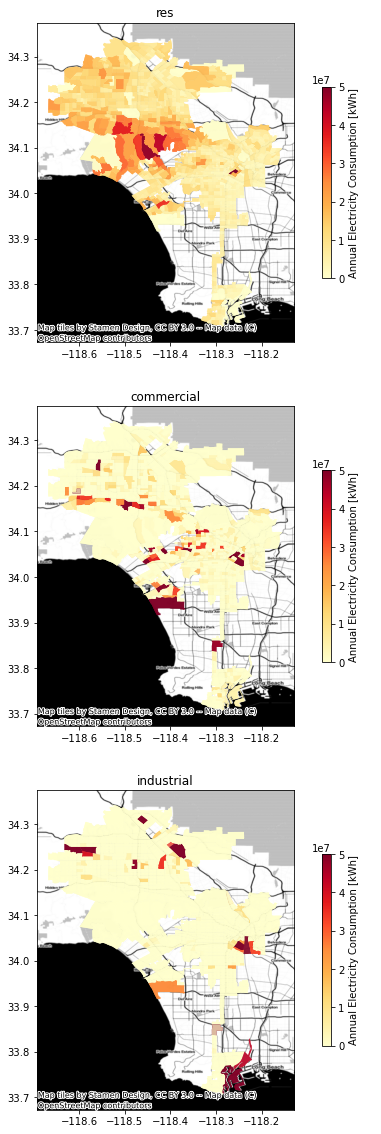

In [52]:
# plot annual electricity consumption by usetype (res, com, ind)
building_type = ['res', 'commercial', 'industrial']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
for i in range(3): 
    gdf_filter = electricity_annual_gdf[electricity_annual_gdf['usetype'] == building_type[i]]
    gdf_filter.plot(ax=axes[i], column='usage', alpha=0.7, legend=True, 
                cmap='YlOrRd',
                vmin = 0, vmax = 5*(10**7), 
                legend_kwds={'label':'Annual Electricity Consumption [kWh]', 'shrink': 0.6})

    axes[i].set_title(building_type[i])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # ax.set_xlim(extent[0], extent[2])
    # ax.set_ylim(extent[1], extent[3])

    ctx.add_basemap(ax=axes[i], source=ctx.providers.Stamen.Toner, crs=gdf_filter.crs) # notice the crs must match between basemap and data
    #plt.savefig('ahf_b_res.jpg')

In [ ]:
# compare energy consumption at different aggregation levels (neighborhood vs. census tract)


In [5]:
natgas_annual

,geoid,usage,sqft,usage_med_sqft,usetype,year
0,6037113401,-7777.0,-7777,-7777.000000,agriculture,2014
1,6037113401,-7777.0,-7777,-7777.000000,agriculture,2015
2,6037113401,-7777.0,-7777,-7777.000000,agriculture,2016
3,6037113401,-9999.0,4956147,0.213349,all,2014
4,6037113401,-9999.0,4957904,0.235451,all,2015
...,...,...,...,...,...,...
38956,6037191720,-9999.0,73981,0.212179,single_family,2015
38957,6037191720,-9999.0,73981,0.250000,single_family,2016
38958,6037191720,-7777.0,-7777,-7777.000000,uncat,2014
38959,6037191720,-7777.0,-7777,-7777.000000,uncat,2015


In [15]:
# number of unique census tracts?
# Note: census tract gpd dataframe includes tracts from outside LA county as well
num_census_tracts = len(electricity_annual.geoid.unique())
num_census_tracts

999

In [24]:
type(electricity_annual.geoid[0])

numpy.int64

In [29]:
test_FIP = census_tracts.FIPS[0]
#test_FIP = int(test_FIP)
print(type(test_FIP))
print(test_FIP)

<class 'numpy.int64'>
6083980100


In [ ]:
# plot annual electricity consumption 
